<a href="https://colab.research.google.com/github/PeiWW/Sample-Code/blob/main/code_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python version: Python 3.7.14
# pandas version: 1.3.5
# numpy version: 1.21.6
# matplotlib.pyplot version: 3.2.2
# PyTorch version: 1.12.1+cu113

In [ ]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module
from torch.nn import Sequential
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import BatchNorm2d
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch.nn import Dropout2d
from torch.nn import CrossEntropyLoss
from torch.nn import BatchNorm1d

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Load Dataset TUDataset/MUTAG

from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.loader import DataLoader
# dataset = KarateClub(transform=NormalizeFeatures())
dataset = TUDataset(root='data/TUDataset', name='MUTAG', transform=NormalizeFeatures())
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
train_dataset = dataset[: int(len(dataset) * 0.8)]
test_dataset = dataset[int(len(dataset) * 0.8): ]
print('==== train_dataset =====')
print(train_dataset)
print('==== test_dataset =====')
print(test_dataset)

# the batch_size here has been changed from 4 to 8 to 16 to produce the 3 graphs.
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


## outputs:
# Dataset: MUTAG(188):
# ======================
# Number of graphs: 188
# Number of features: 7
# Number of classes: 2
# ==== train_dataset =====
# MUTAG(150)
# ==== test_dataset =====
# MUTAG(38)

# For all tasks:
# hidden_dim: 64
# number of layers: 2
# activation: ReLU
# use Adam with learning rate = 0.01

Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2
==== train_dataset =====
MUTAG(150)
==== test_dataset =====
MUTAG(38)


In [ ]:
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool

class GIN(Module):
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_features, dim_h),
                       ReLU(),
                       Linear(dim_h, dim_h),
                       ReLU(),
                       BatchNorm1d(dim_h)))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), 
                       ReLU(),
                       Linear(dim_h, dim_h), 
                       ReLU(),
                       BatchNorm1d(dim_h)))
        
        self.lin1 = Linear(dim_h*2, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h1 = self.conv1(x, edge_index)
        h1 = F.relu(h1)
        h1 = F.dropout(h1, p=0.5, training=self.training)
        h2 = self.conv2(h1, edge_index)

        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)

        h = torch.cat((h1, h2), dim=1)

        hidden = h

        # Classifier
        h = self.lin1(h)
        #h = F.dropout(h, p=0.5, training=self.training)
        
        return hidden, F.log_softmax(h, dim=1)


model = GIN(dim_h = 64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0000001)
criterion = CrossEntropyLoss()

def train(model, loader):
    criterion = CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)
    epochs = 30

    all_train_acc = []
    all_train_loss = []
    all_test_acc = []

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        acc = 0

        # Train on batches
        for data in loader:
          optimizer.zero_grad()
          _, out = model(data.x, data.edge_index, data.batch)
          loss = criterion(out, data.y)
          total_loss += loss
          acc += accuracy(out.argmax(dim=1), data.y) / len(loader)
          loss.backward()
          optimizer.step()

        all_train_acc.append(acc)
        all_train_loss.append(total_loss)

        # Print metrics
        print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} '
              f'| Train Acc: {acc*100:>5.2f}% ')
          
        test_loss, test_acc = test(model, test_loader)
        all_test_acc.append(test_acc)
        print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')
    
    return all_train_acc, all_train_loss, all_test_acc

@torch.no_grad()
def test(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
        _, out = model(data.x, data.edge_index, data.batch)
        loss += criterion(out, data.y)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

In [ ]:
all_train_acc, all_train_loss, all_test_acc = train(model, train_loader)

Epoch   0 | Train Loss: 16.56 | Train Acc: 65.62% 
Test Loss: 215.03 | Test Acc: 68.42%
Epoch   1 | Train Loss: 19.41 | Train Acc: 62.50% 
Test Loss: 16.78 | Test Acc: 76.32%
Epoch   2 | Train Loss: 8.47 | Train Acc: 67.50% 
Test Loss: 19.21 | Test Acc: 68.42%
Epoch   3 | Train Loss: 6.49 | Train Acc: 74.37% 
Test Loss: 18.82 | Test Acc: 65.79%
Epoch   4 | Train Loss: 4.84 | Train Acc: 77.08% 
Test Loss: 17.66 | Test Acc: 78.95%
Epoch   5 | Train Loss: 4.07 | Train Acc: 81.25% 
Test Loss: 29.40 | Test Acc: 68.42%
Epoch   6 | Train Loss: 5.91 | Train Acc: 74.58% 
Test Loss: 27.03 | Test Acc: 73.68%
Epoch   7 | Train Loss: 5.21 | Train Acc: 75.21% 
Test Loss: 17.27 | Test Acc: 73.68%
Epoch   8 | Train Loss: 4.30 | Train Acc: 77.71% 
Test Loss: 20.76 | Test Acc: 78.95%
Epoch   9 | Train Loss: 3.99 | Train Acc: 83.75% 
Test Loss: 16.98 | Test Acc: 76.32%
Epoch  10 | Train Loss: 4.37 | Train Acc: 82.08% 
Test Loss: 16.98 | Test Acc: 78.95%
Epoch  11 | Train Loss: 4.31 | Train Acc: 79.79% 
T

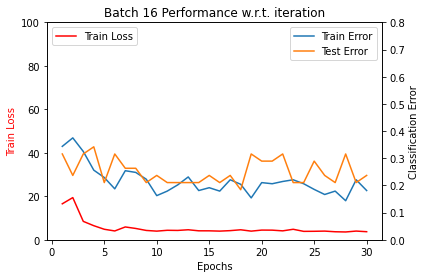

In [ ]:
# Train Accuracy
x = list(np.arange(1, 31))
y1 = [i.detach().numpy().tolist() for i in all_train_loss]
y2 = [1-x for x in all_train_acc]
y3 = [1-x for x in all_test_acc]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(x, y1, 'r-')
ax2.plot(x, y2)
ax2.plot(x, y3)

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Train Loss', color='r')
ax2.set_ylabel('Classification Error')

ax1.legend(["Train Loss"], loc ="upper left")
ax2.legend(['Train Error', 'Test Error'], loc ="upper right")


ax1.set_ylim([0, 100])
ax2.set_ylim([0, 0.80])


plt.title('Batch 16 Performance w.r.t. iteration')

plt.show()